# Extended Data Figure 7 - Ye et al. 2023

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from ruamel.yaml import YAML
from matplotlib.collections import LineCollection
from ruamel.yaml import YAML
from scipy import signal
import matplotlib.colors as mcolors


import pandas as pd
import json
plt.rcParams['axes.labelsize'] = 17  # for x and y labels
plt.rcParams['xtick.labelsize'] = 17 # for x axis tick labels
plt.rcParams['ytick.labelsize'] = 17 # for y axis tick labels
plt.rcParams['axes.titlesize'] = 17

In [7]:

template = '../data/Extended_Figure7/frame_{}.jpg'
frame_indices = [1000, 1200, 1300, 1400]
raw_images = [template.format(index) for index in frame_indices]



json_path = '../data/Extended_Figure7/XBWX0KKOQWMHE6HNY1FL.json'

with open(json_path, 'r') as f:
    json_obj = json.load(f)


superanimal_predictions = [json_obj[str(index)] for index in frame_indices]


In [8]:
import cv2
import numpy as np
import json

def plot_keypoints_and_bbox(image_file, superanimal_prediction, kpt_thr=0.6, kpt_width=3, skeleton_width=1, keep_topk = None):
    # Read the JSON file for dataset information
    with open('../data/supertopview_dataset.json') as f:
        dataset_info = json.load(f)
        keypoint_info = dataset_info['dataset_info']['keypoint_info']
        skeleton_info = dataset_info['dataset_info']['skeleton_info']

    # Create a dictionary for keypoint names to IDs and colors
    kpt_name_2_id = {v['name']: v['id'] for k, v in keypoint_info.items()}
    kpt_colors = [v['color'] for k, v in keypoint_info.items()]

    kpt_colors = [
        [127, 0, 255], [109, 28, 254], [91, 56, 253], [71, 86, 251],
        [53, 112, 248], [33, 139, 244], [15, 162, 239], [4, 185, 234],
        [22, 203, 228], [42, 220, 220], [60, 233, 213], [80, 244, 204],
        [98, 250, 195], [118, 254, 185], [136, 254, 175], [156, 250, 163],
        [174, 244, 152], [194, 233, 139], [212, 220, 127], [232, 203, 113],
        [250, 185, 100], [255, 162, 86], [255, 139, 72], [255, 112, 57],
        [255, 86, 43], [255, 56, 28], [255, 28, 14]
    ]


    # Prepare color pairs for skeleton links
    n_kpts = 27
    pair_2_color = np.ones((n_kpts, n_kpts, 3), dtype=np.uint8) * 255  # Default to white
    for skeleton_id, skeleton in skeleton_info.items():
        if 'antler' in skeleton['link'][0] or 'antler' in skeleton['link'][1]:
            continue
        p1, p2 = kpt_name_2_id[skeleton['link'][0]], kpt_name_2_id[skeleton['link'][1]]

        color = skeleton['color']
        pair_2_color[p1][p2] = color
        pair_2_color[p2][p1] = color

    # Read keypoints and bbox from the provided JSON file


    confidences = []
    for pair in superanimal_prediction:
        keypoints = np.array(pair['keypoints'])
        bbox = np.array(pair['bbox'])[:4]
        confidence = np.array(pair['bbox'])[4]
        confidences.append(confidence)

    confidences = np.array(confidences)

    sorted_indices = np.argsort(confidences)[::-1]
    # Take the first two indices to get the indices of the two largest values
    if keep_topk:
        top_indices = sorted_indices[:keep_topk]

    img = cv2.imread(image_file)


    if keep_topk:
        superanimal_prediction = np.array(superanimal_prediction)
        superanimal_prediction = superanimal_prediction[top_indices]


#     gt_annotations = imagename2anno[image_file.split('/')[-1]]


#     for gt_anno in gt_annotations:
#         keypoints = np.array(gt_anno['keypoints'])
#         keypoints = keypoints.reshape(27, 3)
#         for idx, kpt in enumerate(keypoints):
#             cv2.drawMarker(img, (int(kpt[0]), int(kpt[1])), kpt_colors[idx][::-1], markerType=cv2.MARKER_CROSS, markerSize=kpt_width + 5)


    for pair in superanimal_prediction:

        keypoints = np.array(pair['keypoints'])
        bbox = np.array(pair['bbox'])[:4]

        # Draw bounding box
        cv2.rectangle(img, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 2)

        # Draw keypoints
        for idx, kpt in enumerate(keypoints):
            if kpt[2] > kpt_thr:
                cv2.circle(img, (int(kpt[0]), int(kpt[1])), kpt_width, kpt_colors[idx][::-1], -1)
            else:
                text_size = 0.4  # Adjust text size as needed
                text_thickness = 1  # Adjust text thickness as needed
                cv2.putText(img, 'X', (int(kpt[0]), int(kpt[1])), cv2.FONT_HERSHEY_SIMPLEX,
                    text_size, kpt_colors[idx][::-1], text_thickness, cv2.LINE_AA)

        # Draw skeleton
        for i in range(n_kpts):
            for j in range(n_kpts):
                if i != j and not np.all(pair_2_color[i][j] == 255):  # Check if the color is not default white
                    if keypoints[i][2] >= kpt_thr and keypoints[j][2] >= kpt_thr:
                        cv2.line(img, (int(keypoints[i][0]), int(keypoints[i][1])),
                                 (int(keypoints[j][0]), int(keypoints[j][1])),
                                 pair_2_color[i][j].tolist(), skeleton_width)

        # Save the result image
        title = 'pred_' + image_file.split('/')[-1]
        cv2.imwrite(title, img)
    return img

## Raw video frames from MABe trimouse 

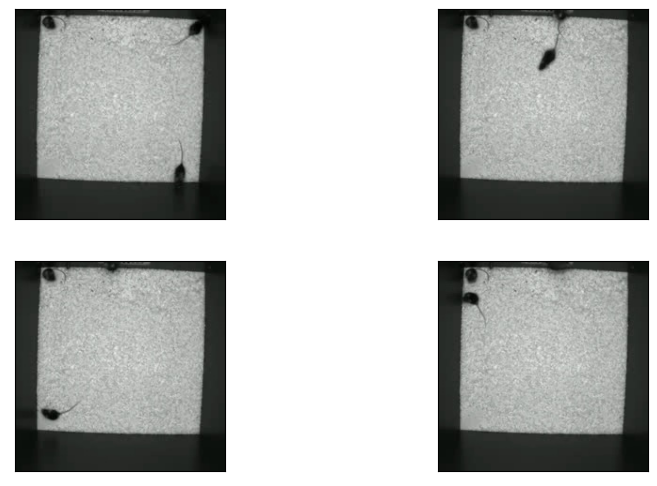

In [9]:
fig, axes = plt.subplots(2,2)

for idx in range(4):
    row = idx //2
    col = idx % 2


    file = raw_images[idx]
    img =  mpimg.imread(file)
    axes[row][col].imshow(img)
    axes[row][col].set_xticks([])
    axes[row][col].set_yticks([])

fig.set_size_inches(10, 6)
plt.show()

## Top-down SuperAnimal-TopviewMouse's zeroshot on MABe frames

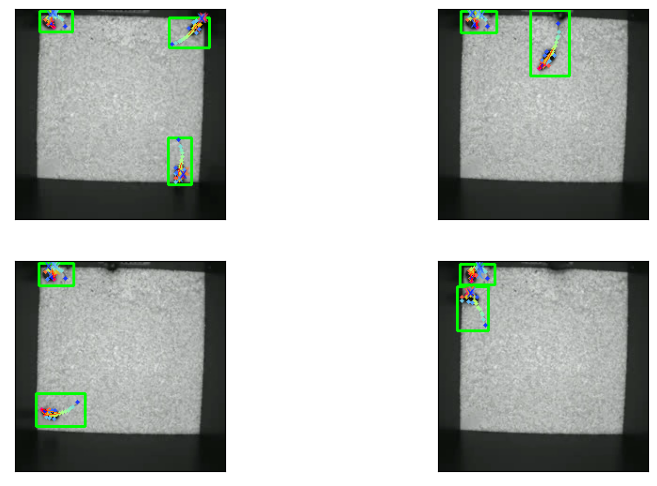

In [10]:
fig, axes = plt.subplots(2,2)

for idx in range(4):
    row = idx //2
    col = idx % 2


    image_file = raw_images[idx]
    imagename = image_file.split('/')[-1]

    img = plot_keypoints_and_bbox(image_file, superanimal_predictions[idx], kpt_thr=0.3, kpt_width=2, skeleton_width=1, keep_topk = 3)
    axes[row][col].imshow(img)
    axes[row][col].set_xticks([])
    axes[row][col].set_yticks([])

fig.set_size_inches(10, 6)
plt.show()

## Result comparison between the official pose and superanimal pose

In [17]:
mabe_official_pose = '../data/Extended_Figure7/mouse-round-1--submission_pointnet_gt.npy.csv'
mabe_superanimal_pose = '../data/Extended_Figure7/mouse-round-1--submission_pointnet_modelzoo.npy.csv'


mabe_official_pose_result = pd.read_csv(mabe_official_pose)
mabe_superanimal_pose_result = pd.read_csv(mabe_superanimal_pose)


mabe_official_pose_result = mabe_official_pose_result.loc[:, ['Task ID', 'Private Score']]

mabe_superanimal_pose_result = mabe_superanimal_pose_result.loc[:, ['Task ID', 'Private Score']]


data = {
    'MABe official pose': mabe_official_pose_result.loc[:, 'Private Score'].to_numpy(),
    'SuperAnimal Zero-shot pose':  mabe_superanimal_pose_result.loc[:, 'Private Score'].to_numpy()
}


task_ids = mabe_official_pose_result['Task ID']

df = pd.DataFrame(data, index=task_ids)

print (df)


                      MABe official pose  SuperAnimal Zero-shot pose
Task ID                                                             
experiment_day                  0.095018                    0.095018
time_of_day                     0.096345                    0.096350
strain                          0.657165                    0.657245
approaches                      0.020959                    0.020963
chases                          0.034015                    0.034020
close                           0.718520                    0.718519
contact                         0.565967                    0.565954
huddles                         0.261730                    0.261697
oral_ear_contact                0.005427                    0.005427
oral_genital_contact            0.025384                    0.025381
oral_oral_contact               0.021717                    0.021703
watching                        0.107985                    0.107988
lights                          0.

In [20]:
formatted_df = df.round(3)

# Convert the DataFrame to LaTeX table format
latex_table = formatted_df.to_latex(index=False)

print(latex_table)

\begin{tabular}{rr}
\toprule
 MABe official pose &  SuperAnimal Zero-shot pose \\
              0.095 &                       0.095 \\
\midrule
              0.096 &                       0.096 \\
              0.657 &                       0.657 \\
              0.021 &                       0.021 \\
              0.034 &                       0.034 \\
              0.719 &                       0.719 \\
              0.566 &                       0.566 \\
              0.262 &                       0.262 \\
              0.005 &                       0.005 \\
              0.025 &                       0.025 \\
              0.022 &                       0.022 \\
              0.108 &                       0.108 \\
              0.611 &                       0.611 \\
\bottomrule
\end{tabular}



/var/folders/n5/5_x4w2px2wn6hc6n_9zzlygw0000gn/T/ipykernel_3784/3989402781.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = formatted_df.to_latex(index=False)


In [18]:
from scipy.stats import ttest_rel

In [19]:
t_statistic, p_value = ttest_rel(df['MABe official pose'], df['SuperAnimal Zero-shot pose'])

print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Interpretation
if p_value < 0.05:
    print("There is a statistically significant difference between the two methods.")
else:
    print("There is no statistically significant difference between the two methods.")

T-statistic: -0.017319310219163324
P-value: 0.9864665127790815
There is no statistically significant difference between the two methods.


## Same as Figure 4 g, with filter

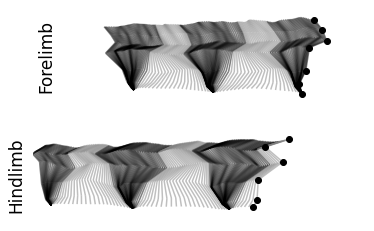

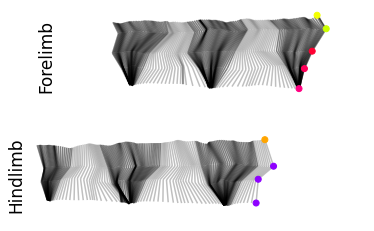

In [8]:
def load_json(json_file):
    with open(json_file) as f:
        data = json.load(f)
    coords = np.full((max(map(int, data)) + 1, len(keypoints), 3), np.nan)
    for ind, list_ in data.items():
        if not list_:
            continue
        coords[int(ind)] = np.array(list_[0]['keypoints'])
    mi = pd.MultiIndex.from_product([['Byron'], keypoints, ['x', 'y']], names=['scorer', 'bodyparts', 'coords'])
    df = pd.DataFrame(
        coords[..., :2].reshape((coords.shape[0], -1)),
        columns=mi
    )
    return df, coords

def get_events(df, event, hoof_kpt_names, ref_kpt_name, min_dist=50, detrend=True):
    keypoints = list(df.columns.get_level_values('bodyparts').unique())
    coords = df.copy().to_numpy().reshape((df.shape[0], -1, 2))
    # Center data
    if ref_kpt_name:
        temp = coords[:, keypoints.index(ref_kpt_name), :2]
        # Evaluate the animal's horizontal displacement when
        # the reference point is unseen.
        t = np.arange(coords.shape[0])
        mask = ~np.isnan(temp).any(axis=1)
        temp[:, 0] = np.poly1d(np.polyfit(np.flatnonzero(mask), temp[mask, 0], 1))(t)
        temp[:, 1] = np.poly1d(np.polyfit(np.flatnonzero(mask), temp[mask, 1], 1))(t)
        coords[..., :2] -= temp[:, None]
    events = []
    for pt in hoof_kpt_names:
        x = coords[:, keypoints.index(pt), 0]
        if event == 'lift':
            x = -x
        if detrend:
            signal.detrend(x[~np.isnan(x)], overwrite_data=True)
        events.append(signal.find_peaks(
            x,
            distance=min_dist,
        )[0])
    return events, coords

def get_stances(contacts, lifts):
    stances = []
    for contacts_, lifts_ in zip(contacts, lifts):
        temp = set()
        for c1, c2 in zip(contacts_[:-1], contacts_[1:]):  # Individual strides
            lift = lifts_[(lifts_ > c1) & (lifts_ < c2)]
            if not lift.size:
                continue
            temp.add((c1, lift[0]))
        for l1, l2 in zip(lifts_[:-1], lifts_[1:]):
            contact = contacts_[(contacts_ > l1) & (contacts_ < l2)]
            if not contact.size:
                continue
            temp.add((contact[0], l2))
        stances.append(list(temp))
    return stances

def _make_line_collection(coords, inds_stance, links, start=0, end=-1, color_stance='plum', alpha=0.5):
    mask_stance = np.zeros(coords.shape[0], dtype=bool)
    for inds in inds_stance:
        mask_stance[inds[0]:inds[1] + 1] = True
    color = mcolors.to_rgb('gray')
    colors = np.array([color] * len(coords))
    colors[mask_stance] = mcolors.to_rgb(color_stance)
    sl = slice(start, end)
    colors = colors[sl]
    segs = coords[sl, links].reshape((-1, 2, 2))
    colors = np.repeat(colors, len(links), axis=0)
    coll = LineCollection(segs, colors=colors, alpha=alpha)
    return coll, segs

with open('../data/Figure4/keypoints.yaml') as f:
    cfg = YAML().load(f)
    keypoints = list(cfg['all_joints_names'])

hooves_gt = 'Offfrontfoot', 'Offhindfoot'
ref_kpt_name_gt = 'Wither'
hooves = 'front_right_paw', 'back_right_paw'
ref_kpt_name = 'back_base'
front_limb_gt = [
    ('Offfrontfoot', 'Offfrontfetlock'),
    ('Offknee', 'Offfrontfetlock'),
    ('Offknee', 'Elbow'),
    ('Shoulder', 'Elbow'),
    ('Shoulder', 'Midshoulder'),
    ('Wither', 'Midshoulder'),
]
hind_limb_gt = [
    ('Offhindfoot', 'Offhindfetlock'),
    ('Offhindhock', 'Offhindfetlock'),
    ('Offhindhock', 'Stifle'),
    ('Ischium', 'Stifle'),
    ('Ischium', 'Hip'),
]
front_limb = [
    ('front_right_paw', 'front_right_knee'),
    ('front_right_thai', 'front_right_knee'),
    ('front_right_thai', 'neck_base'),
    ('back_base', 'neck_base'),
]
hind_limb = [
    ('back_right_paw', 'back_right_knee'),
    ('back_right_thai', 'back_right_knee'),
    ('back_right_thai', 'tail_base'),
]

# Load SA predictions and GT
df, coords = load_json('../data/Figure4/Brownhorseoutofshadow.mp4.json')
df_gt = pd.read_hdf('../data/Figure4/CollectedData_Byron.h5')
keypoints_gt = list(df_gt.columns.get_level_values('bodyparts').unique())
links_front_limb_gt = [tuple(keypoints_gt.index(pt) for pt in pts) for pts in front_limb_gt]
links_hind_limb_gt = [tuple(keypoints_gt.index(pt) for pt in pts) for pts in hind_limb_gt]
links_front_limb = [tuple(keypoints.index(pt) for pt in pts) for pts in front_limb]
links_hind_limb = [tuple(keypoints.index(pt) for pt in pts) for pts in hind_limb]

# Apply a zero-phase, low-pass Butterworth filter to smooth the data
cutoff = 3
b, a = signal.butter(2, cutoff, fs=24)
mask = df.isna()
df[mask] = 0
df[:] = signal.filtfilt(b, a, df, axis=0)
df[mask] = np.nan
sl = slice(50, -50)  # Trim the start and end of the data, when the horse is not fully seen
df = df.iloc[sl]
coords = df.to_numpy().reshape((len(df), -1, 2))

mask = df_gt.isna()
df_gt[mask] = 0
df_gt[:] = signal.filtfilt(b, a, df_gt, axis=0)
df_gt[mask] = np.nan
df_gt = df_gt.iloc[sl]
coords_gt = df_gt.to_numpy().reshape((df_gt.shape[0], -1, 2))

# Get hoof contacts and lifts
contacts, _ = get_events(df, 'contact', hooves, ref_kpt_name)
lifts, _ = get_events(df, 'lift', hooves, ref_kpt_name)
stances = get_stances(contacts, lifts)

contacts_gt, _ = get_events(df_gt, 'contact', hooves_gt, ref_kpt_name_gt)
lifts_gt, _ = get_events(df_gt, 'lift', hooves_gt, ref_kpt_name_gt)
stances_gt = get_stances(contacts_gt, lifts_gt)

s, e = 35, 35
coll_gt, segs_gt = _make_line_collection(coords_gt, stances_gt[0], links_front_limb_gt, start=s, end=-e, color_stance='k')
coll_gt2, segs_gt2 = _make_line_collection(coords_gt, stances_gt[1], links_hind_limb_gt, start=s, end=-e, color_stance='k')
fig, axes = plt.subplots(nrows=2, sharex=True, sharey=True)
for ax in axes:
    sns.despine(ax=ax, left=True, bottom=True)
    ax.set_xticks([])
    ax.set_yticks([])
axes[0].set_aspect('equal')
xmin, ymin = np.nanmin(np.r_[segs_gt, segs_gt2], axis=(0, 1))
xmax, ymax = np.nanmax(np.r_[segs_gt, segs_gt2], axis=(0, 1))
axes[0].set_xlim(xmin, xmax + 10)
axes[0].set_ylim(ymin - 10, ymax + 10)
axes[0].invert_yaxis()
axes[0].add_collection(coll_gt)
axes[0].set_ylabel('Forelimb')
temp = coords_gt[s:-e, list(set(kpt for p in links_front_limb_gt for kpt in p))]
axes[0].scatter(*temp[-1].T, zorder=99, c='k')
axes[1].add_collection(coll_gt2)
axes[1].set_ylabel('Hindlimb')
temp = coords_gt[s:-e, list(set(kpt for p in links_hind_limb_gt for kpt in p))]
axes[1].scatter(*temp[-1].T, zorder=99, c='k')

coll, segs = _make_line_collection(coords, stances[0], links_front_limb, start=s, end=-e, color_stance='k')
coll2, segs2 = _make_line_collection(coords, stances[1], links_hind_limb, start=s, end=-e, color_stance='k')
fig, axes = plt.subplots(nrows=2, sharex=True, sharey=True)
for ax in axes:
    sns.despine(ax=ax, left=True, bottom=True)
    ax.set_xticks([])
    ax.set_yticks([])
axes[0].set_aspect('equal')
axes[0].set_xlim(xmin, xmax + 10)
axes[0].set_ylim(ymin - 10, ymax + 10)
axes[0].invert_yaxis()
axes[0].add_collection(coll)
forelimb_point_colors = {
    'back_base': '#F3FF00',
    'neck_base': '#CBFF00',
    'front_right_thai': '#FF0032',
    'front_right_knee': '#FF0059',
    'front_right_paw': '#FF0081',
}
inds_points = [keypoints.index(kpt) for kpt in forelimb_point_colors]
temp = coords[s:-e, inds_points]
axes[0].scatter(*temp[-1].T, c=list(forelimb_point_colors.values()), zorder=99)
axes[0].set_ylabel('Forelimb')
axes[1].add_collection(coll2)
axes[1].set_ylabel('Hindlimb')
hindlimb_point_colors = {
    'tail_base': '#FFA500',
    'back_right_thai': '#8E00FF',
    'back_right_knee': '#8E00FF',
    'back_right_paw': '#8E00FF',
}
inds_points = [keypoints.index(kpt) for kpt in hindlimb_point_colors]
temp = coords[s:-e, inds_points]
axes[1].scatter(*temp[-1].T, c=list(hindlimb_point_colors.values()), zorder=99)